A proof of concept / Exploration of the idea of using a classefier as a perceptual loss function.




In [1]:
if True:
    !pip install torchinfo
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageFile
import requests
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt
import torchvision.models as models
import time
import torchinfo
from torchvision.io import read_image
from torch.utils.data import Dataset
import time
import datetime


from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader

device = torch.device("cpu")
if torch.cuda.is_available():
    pass
    device = torch.device("cuda")

print("Device: {}".format(device))


# utils
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Device: cuda


<ipython-input-1-04c7da2e6e9d>:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## TODO
- [x] cache noise
- [ ]


In [ ]:
def normal_noise_np(img: np.array, noise_intensity=0.2):
    pix = img.copy()

    pix += np.random.normal(size=pix.shape) * noise_intensity
    pix.clip(0.0, 1.0)

    return pix

def normal_noise(img: torch.tensor, noise_intensity=0.3):
    noisy = img + torch.normal(mean=0.0, std=noise_intensity, size=img.shape)
    return torch.clamp(noisy, min=0.0, max=1.0)

def poisson_noise(img: torch.Tensor, rate=100):
    return torch.poisson(torch.clamp(img, 0.1, 1.0) * rate) / rate



def to_image(img):
    #todo
    return None



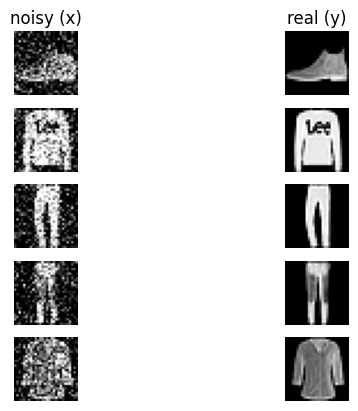

In [ ]:

class NoiseDataset(Dataset):
    def __init__(self, dataset, noise_fn, cache_data=False, size_cap=None, img_extract_fn=None):

        self.dataset = dataset
        self.noise_fn = noise_fn
        self.transform = transforms.ToTensor()
        self.img_extract_fn = img_extract_fn
        self.len = len(self.dataset) if (size_cap == None or size_cap == -1) else min(len(self.dataset), size_cap)
        self.cache_data = cache_data
        self.cache = [None for _ in range(self.len)] if self.cache_data else None

    def __len__(self):
        return self.len

    def __getitem__(self, idx):

        if self.cache_data and (self.cache[idx] is not None):
            return self.cache[idx]

        image = None
        if self.img_extract_fn is None:
            image, _ = self.dataset[idx]
        else:
            image, _ = self.img_extract_fn(self.dataset[idx])

        #image_real = image.clamp(0.2, 1.0)
        image_real = image.clamp(0.01, 1.0)
        image_noisy = self.noise_fn(image_real)



        if self.cache_data:
            self.cache[idx] = (image_noisy, image_real)

        return image_noisy, image_real

training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)


testing_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

training_data_noise = NoiseDataset(training_data, normal_noise, size_cap=None, cache_data=False)
testing_data_noise = NoiseDataset(testing_data, normal_noise, size_cap=None, cache_data=False)

training_dataloader = DataLoader(training_data_noise, batch_size=32, num_workers=2)
testing_dataloader = DataLoader(testing_data_noise, batch_size=32, num_workers=2)




fig, axs = plt.subplots(5, 2)

axs[0,0].set_title("noisy (x)")
axs[0,1].set_title("real (y)")

for i in range(5):
    x, y = testing_dataloader.dataset[i]


    axs[i,0].set_axis_off()
    axs[i,1].set_axis_off()


    axs[i,0].imshow(x.cpu().reshape((28,28)), cmap='gray')
    axs[i,1].imshow(y.cpu().reshape((28,28)), cmap='gray')



In [ ]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ).to(device)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1,
                               kernel_size=3, # unet uses 2?
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.Sigmoid()
        ).to(device)


    def forward(self, x):
        x = x.to(device)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


m = Autoencoder()
m = m.to(device)
torchinfo.summary(m, testing_dataloader.dataset[0][0].shape)


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 28, 28]               --
├─Sequential: 1-1                        [32, 7, 7]                --
│    └─Conv2d: 2-1                       [16, 28, 28]              160
│    └─ReLU: 2-2                         [16, 28, 28]              --
│    └─MaxPool2d: 2-3                    [16, 14, 14]              --
│    └─Conv2d: 2-4                       [32, 14, 14]              4,640
│    └─ReLU: 2-5                         [32, 14, 14]              --
│    └─MaxPool2d: 2-6                    [32, 7, 7]                --
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─ConvTranspose2d: 2-7              [16, 14, 14]              4,624
│    └─ReLU: 2-8                         [16, 14, 14]              --
│    └─ConvTranspose2d: 2-9              [1, 28, 28]               145
│    └─Sigmoid: 2-10                     [1, 28, 28]               --
Total p

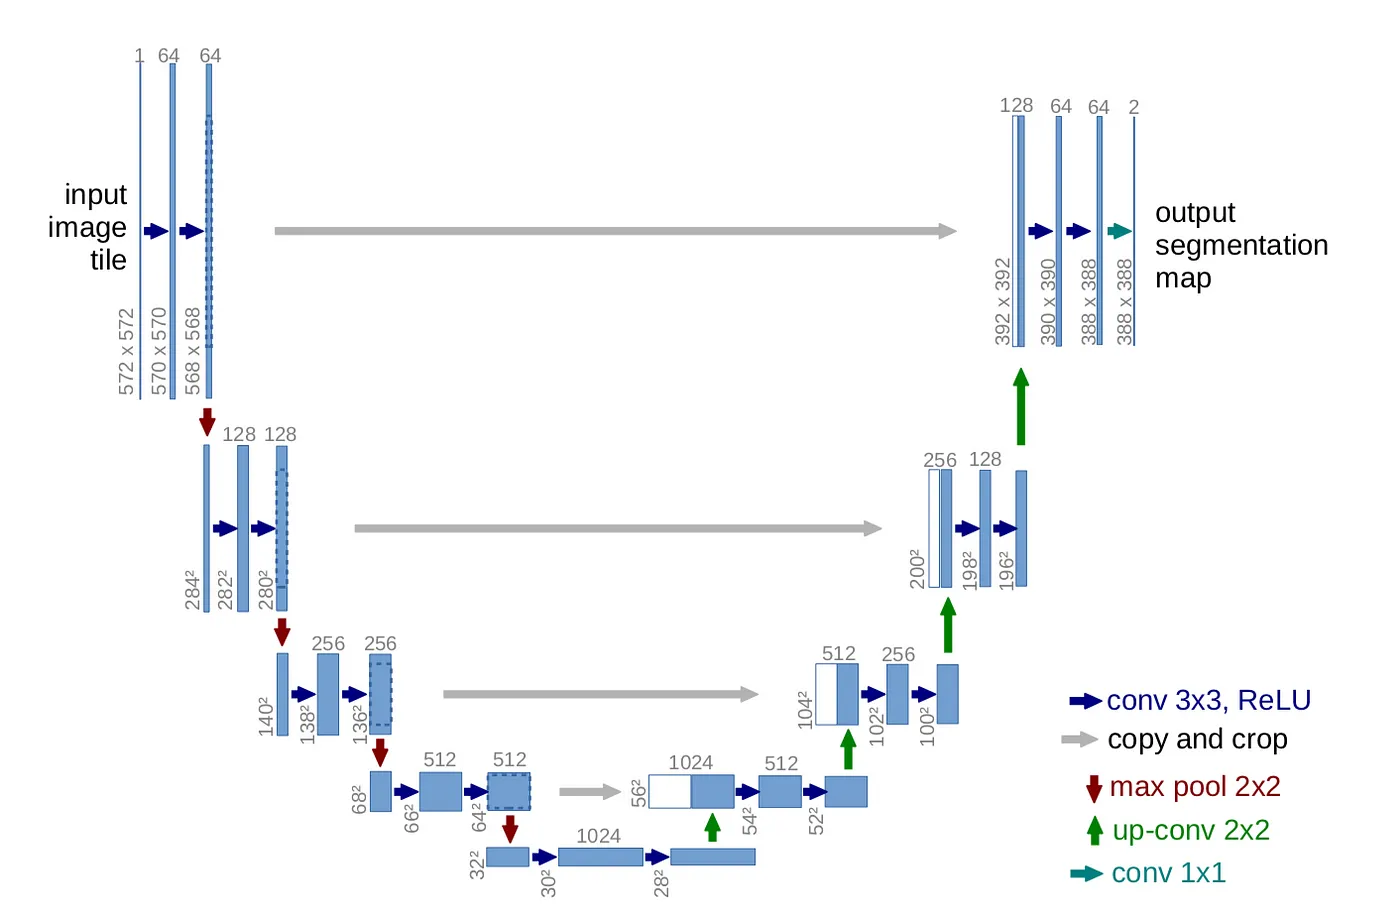https://miro.medium.com/v2/resize:fit:720/format:webp/1*zYrwp34DslR_9wLHMVAITg.png


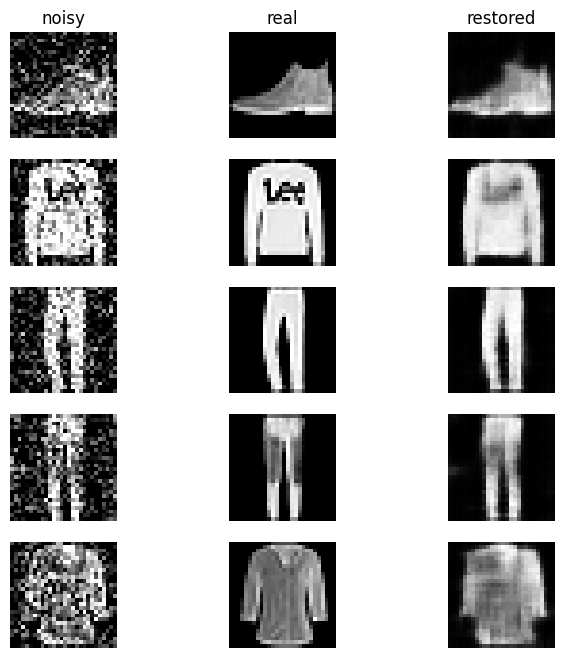


Epoch [1/10]
Loss - Train: 0.0207   Test: 0.0130
Time - since start: 24.5   this epoch: 20.5
(note: 'since start' does include total testing...)



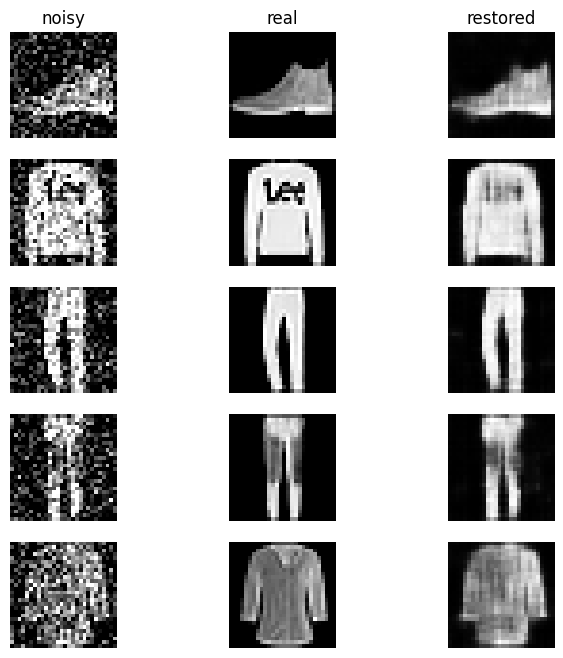


Epoch [2/10]
Loss - Train: 0.0122   Test: 0.0117
Time - since start: 46.4   this epoch: 23.0
(note: 'since start' does include total testing...)



KeyboardInterrupt: 

In [ ]:
# Options
NUM_EPOCHS = 10
NUM_IMG_EXAMPLES = 5
NUM_TESTING_EPOCHS = 10 # in addition to last

# Time and logging
start_time = time.time()
last_epoch_time = time.time()# to be updated

training_loss_hist = []
testing_loss_hist = []
testing_epoch_is = []



# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(m.parameters(), lr=0.001)

# Train the autoencoder

for epoch in range(NUM_EPOCHS):
    m.train()

    progress_log = epoch % (NUM_EPOCHS / NUM_TESTING_EPOCHS) == 0 or epoch == NUM_EPOCHS - 1

    train_loss_acc = 0.0

    for x_batch, y_batch in training_dataloader:
        optimizer.zero_grad()
        output = m(x_batch)
        loss = criterion(y_batch.to(device), output)
        loss.backward()
        optimizer.step()
        train_loss_acc += loss.item()

    train_loss = train_loss_acc / len(training_dataloader)
    training_loss_hist.append(train_loss)


    epoch_time = time.time() - last_epoch_time
    last_epoch_time = time.time()

    if progress_log:
        testing_epoch_is.append(epoch)
        m.eval()

        test_loss_acc = 0.0
        for x_test_batch, y_test_batch in testing_dataloader:
            output = m(x_test_batch.to(device))
            loss = criterion(y_test_batch.to(device), output)
            test_loss_acc += loss.item()

        test_loss = test_loss_acc / len(testing_dataloader)
        testing_loss_hist.append(test_loss)


        fig, axs = plt.subplots(NUM_IMG_EXAMPLES, 3, figsize=(8, 8))

        axs[0,0].set_title("noisy")
        axs[0,1].set_title("real")
        axs[0,2].set_title("restored")

        for i in range(NUM_IMG_EXAMPLES):
            x, y = testing_dataloader.dataset[i]
            o = m(x.to(device))

            axs[i,0].set_axis_off()
            axs[i,1].set_axis_off()
            axs[i,2].set_axis_off()

            axs[i,0].imshow(x.cpu().reshape((28,28)), cmap='gray')
            axs[i,1].imshow(y.cpu().reshape((28,28)), cmap='gray')
            axs[i,2].imshow(o.cpu().detach().numpy().reshape((28,28)), cmap='gray')

        plt.show()
        print(
"""
Epoch [{}/{}]
Loss - Train: {:.4f}   Test: {:.4f}
Time - since start: {:.1f}   this epoch: {:.1f}
(note: 'since start' does include total testing...)
""".format(epoch+1, NUM_EPOCHS, train_loss, test_loss, time.time() - start_time, epoch_time))


plt.plot( [i+1 for i in range(NUM_EPOCHS)], training_loss_hist, "b:o", label="Train Loss")
plt.plot([i+1 for i in testing_epoch_is], testing_loss_hist,  "r:o", label="Test Loss")
plt.title = "Loss over time"
plt.legend()
plt.show()


torch.save(m.state_dict(), "models/last_model")
torch.save(m.state_dict(), "models/all/[{}]-{}params".format(datetime.datetime.now().strftime("%d%b-%H.%M"), count_parameters(m)))






In [ ]:

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(function.relu(self.conv1(x)))
        x = self.pool(function.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = function.relu(self.fc1(x))
        x = function.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class_m = GarmentClassifier()


loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))


class_training_loader = DataLoader(FashionMNIST)


def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = class_m(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss




# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
#writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    class_m.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    class_m.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    #writer.add_scalars('Training vs. Validation Loss',
    #                { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                epoch_number + 1)
    #writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'class_model_{}_{}'.format(timestamp, epoch_number)
        torch.save(class_m.state_dict(), model_path)

    epoch_number += 1